# Setup
## Import and configure modules

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ["TFHUB_MODAL_LOAD_FORMAT"] = "COMPRESSED"

In [2]:
from IPython import display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [4]:
content_path = tf.keras.utils.get_file(origin='https://github.com/Sann-Htet/Neural-style-transfer/blob/master/images/1_content_image.jpg?raw=true')
style_path = tf.keras.utils.get_file(origin='https://github.com/Sann-Htet/Neural-style-transfer/blob/master/images/1_style_image.jpg?raw=true')

573440/562577 [==============================] - 0s 0us/step


##Visualize the input
Define a function to load an image and limit its maximum dimension to 512 pixels.

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

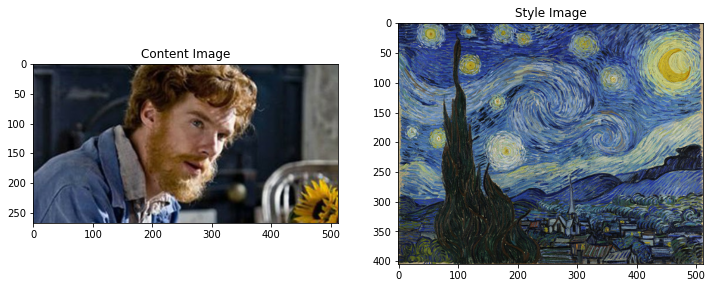

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Fast Style Transfer using TF-Hub

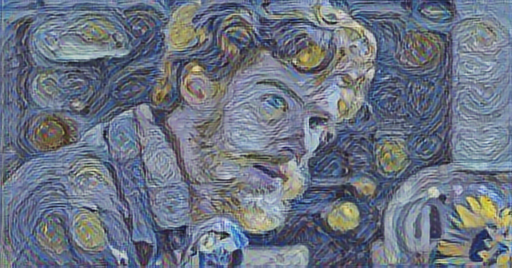

In [8]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

# Define content and style representations
Use the intermediate layers of the model to get the content and style representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As we step through the network, the final few layers represent higher-level features—object parts like wheels or eyes. In this case, we are using the `VGG19` network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.

Load a `VGG19` and test run it on our image to ensure it's used correctly:

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [10]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('stage', 0.095330045),
 ('basketball', 0.08643364),
 ('jersey', 0.05076994),
 ('French_horn', 0.0428636),
 ('steel_drum', 0.037688307)]

Now load a `VGG19` without the classification head, and list the layer names.

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
  print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:



In [12]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Build the model
The networks in `tf.keras.applications` are designed so we can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a `VGG19` model that returns a list of intermediate layer outputs:



In [13]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 405, 512, 64)
  min:  0.0
  max:  659.8009
  mean:  23.626637

block2_conv1
  shape:  (1, 202, 256, 128)
  min:  0.0
  max:  2775.3127
  mean:  146.81274

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7250.1987
  mean:  145.25508

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  16609.324
  mean:  539.8092

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3626.2131
  mean:  44.816074



# Calculate style
The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$G_{cd}^l$ $=$ $\frac{∑_{ij}F_{ijc}^l(x)F_{ijd}^l(x)}{IJ}$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [15]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) # Einstein summation
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

#Extract style and content
Build a model that returns the style and content tensors.

In [16]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers) # create model with the intermediate values
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # calculate gram_matrixes for style feature vectors
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [17]:
extractor = StyleContentModel(style_layers, content_layers) # create a model object

results = extractor(tf.constant(content_image)) # pass the input image

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.024252737
    max:  25271.52
    mean:  431.76984

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  60552.63
    mean:  12202.082

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  337396.4
    mean:  12598.284

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2655688.8
    mean:  193370.61

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  69177.266
    mean:  1586.9749

Contents:
   block5_conv2
    shape:  (1, 16, 32, 512)
    min:  0.0
    max:  1266.4667
    mean:  15.546479


# Run gradient descent
With this style and content extractor, we can now implement the style transfer algorithm. We can do this by calculating the mean square error for our image's output relative to each target, then take the weighted sum of these losses.

Set our style and content target values:

In [18]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

We need to define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [19]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:


In [20]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [21]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [22]:
style_weight=1e-2
content_weight=1e4

In [23]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [24]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

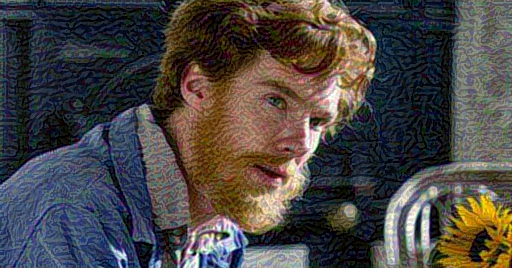

In [25]:
train_step(image)
train_step(image)
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

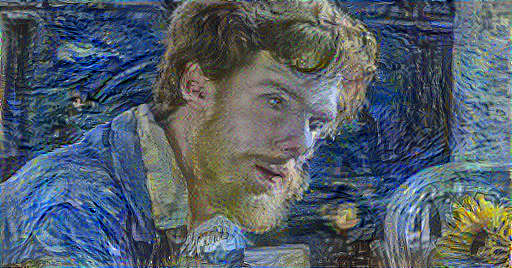

Train step: 1000
Total time: 172.0


In [26]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Total variation loss
One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the `total variation loss`:

In [27]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

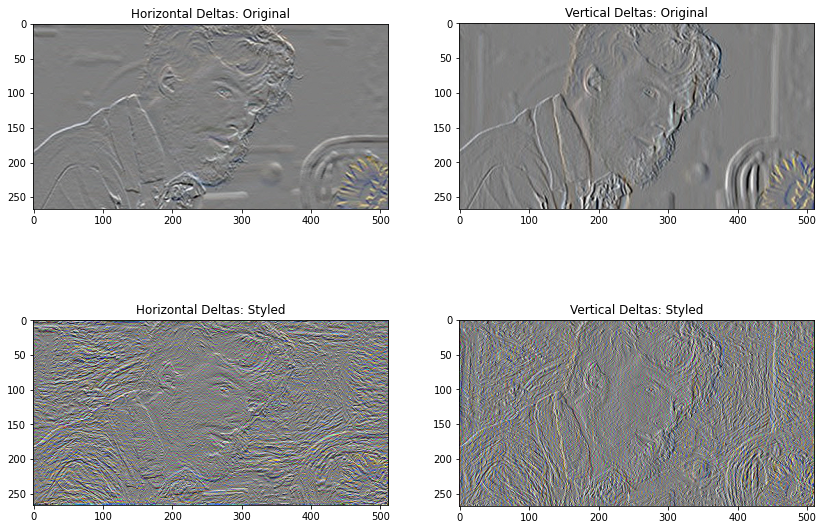

In [28]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. We can get similar output from the Sobel edge detector, for example:

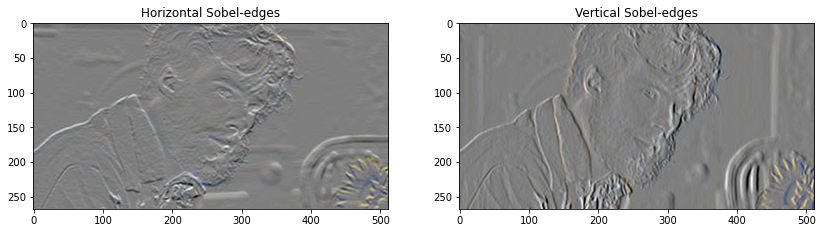

In [29]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [30]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [31]:
total_variation_loss(image).numpy()

74700.84

That demonstrated what it does. But there's no need to implement it ourselves, TensorFlow includes a standard implementation:

In [32]:
tf.image.total_variation(image).numpy()

array([74700.84], dtype=float32)

# Re-run the optimization
Choose a weight for the `total_variation_loss`:

In [33]:
total_variation_weight=30

Now include it in the `train_step` function:

In [34]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the optimization variable:

In [35]:
image = tf.Variable(content_image)

And run the optimization:

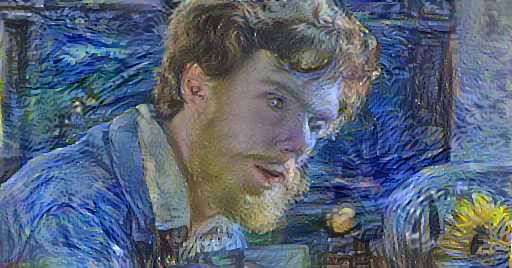

Train step: 1000
Total time: 174.8


In [36]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Finally, save the result:

In [37]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>